In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [11]:
class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super(Bigram, self).__init__()
        self.bigram_embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets = None):
        logits = self.bigram_embedding(x) # Outputs Batch, Time, Channel (Vocab Size) 
        if targets == None:
            loss = None
        else:
            self.B,self.T,self.C = logits.shape
            logits = logits.view(self.B*self.T,self.C)
            targets = targets.contiguous().view(self.B*self.T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1)
            
        return logits, loss

In [12]:
# Set up optimizer
vocab_size = len(vocab) + 1 # +1 for special characters
model = Bigram(vocab_size)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
# Training loop - update to evaluate loss on ongoing basis and printing results, understand whats going on in the bigram model - ie why isnt it working with embedding 
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

for steps in range(5000):
    xb, yb = next(iter(train_dataloader))
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    ltr, lte = evaluate_loss(model, train_dataloader, test_dataloader, num_batches=10)
    tr_loss.append(ltr)
    te_loss.append(lte)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

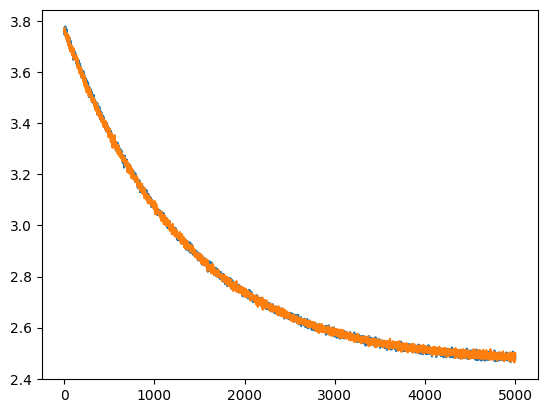

In [14]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss)
plt.plot(te_loss)

plt.show()

In [15]:
## Pretty print the samples
print_samples(model, train_data, max_length, num=10)

m
jaa
ossh
go
le
mi
j
cfucopora
em
alysanzh
